# Quadratic Flux Minimizing Surfaces

Quadratic-Flux-Minimizing (QFM) surfaces are a useful tool in vacuum stellarator optimization, where, given a coil magnetic field, one may extract a surface in space which minimizes the quadratic magnetic flux passing through it, that is,
$$
\begin{equation}
S = \arg\min_S \int_S |B_n|^2 dS
\end{equation}
$$
Where $B_n = \mathbf{B} \cdot \mathbf{n}$ is the normal magnetic field on the surface $S$, and the optimization is understood to be done under the constraint of the surface enclosing some amount of net toroidal magnetic flux. The surface $S$ itself is described typically with a double Fourier series in the poloidal and toroidal angles ([See the docs on basis functions for more details](../basis_grid.ipynb)) describing the cylindrical $R$ and $Z$ coordinates of the surface, so the optimization is done by varying the Fourier coefficients describing the surface (or potentially, the magnetic field's degrees of freedom as well). This short notebook will give an example of using QFM surfaces to extrace a surface from a magnetic field, and then solving the interior equilibrum with DESC and comparing it to the original magnetic field.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [ ]:
# from desc import set_device
# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
from desc.objectives import (
    SurfaceQuadraticFlux,
    ToroidalFlux,
    ObjectiveFunction,
)
from desc.magnetic_fields import SplineMagneticField
from desc.geometry import FourierRZToroidalSurface
from desc.optimize import Optimizer
from desc.grid import LinearGrid
from desc.plotting import plot_2d, poincare_plot, plot_boundary, plot_surfaces
import numpy as np

First, we will load a magnetic field from an ``mgrid`` file (the same as is used in the [stellarator free boundary notebook](./free_boundary_equilibrium.ipynb))

In [5]:
extcur = [4700.0, 1000.0]
field = SplineMagneticField.from_mgrid(
    "../../../tests/inputs/mgrid_test.nc", extcur=extcur
)

Our initial surface is a circular surface, which we see is not well-approximating any flux surfaces in this vacuum field.

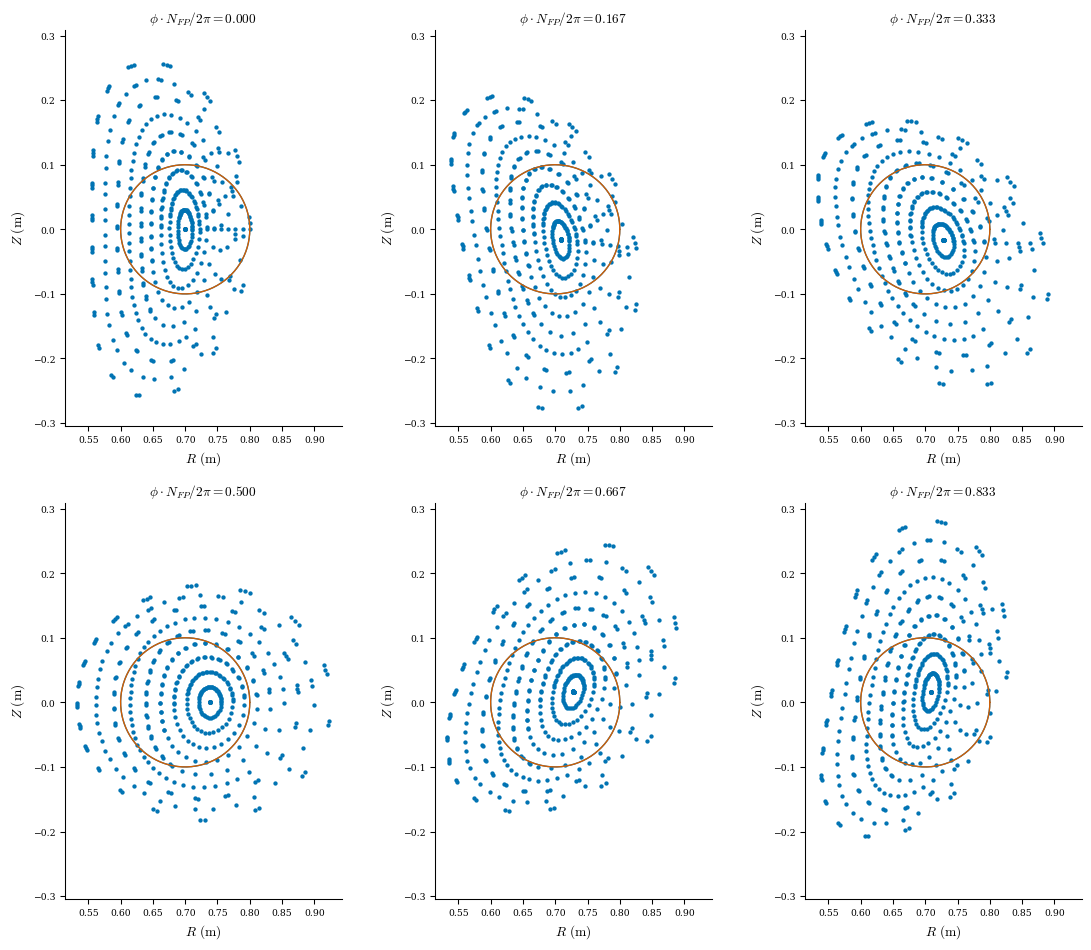

In [6]:
surface0 = FourierRZToroidalSurface(
    R_lmn=[0.7, 0.1],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-0.1],
    modes_Z=[[-1, 0]],
    sym=True,
    NFP=field.NFP,
    M=6,
    N=6,
)
fig, ax = plot_surfaces(surface0, rho=1.0, theta=0)
poincare_plot(
    field,
    R0=np.linspace(0.7, 0.8, 10),
    Z0=np.zeros(10),
    ax=ax,
    NFP=field.NFP,
    ntransit=50,
);

Let's setup the optimization problem to find the QFM surface.

In [7]:
# SurfaceQuadraticFlux objective is the one to use when trying to minimize quadratic flux for a surface
qflux = SurfaceQuadraticFlux(
    surface0,
    field,
    eval_grid=LinearGrid(M=2 * surface0.M, N=2 * surface0.M, NFP=surface0.NFP),
    field_fixed=True,  # field is not being optimized
    bs_chunk_size=10,
)
# Must include a ToroidalFlux or a Volume target to ensure we don't get a trivial solution of the surface collapsing to a point
target_psi = -0.035
tflux = ToroidalFlux(
    surface0,
    field,
    target=target_psi,  # the same toroidal flux as used in the free bdry eq
    eq_fixed=False,  # we will allow the thing passed in (QFM surface in this case) to vary
    field_fixed=True,  # field is not being optimized, so we fix it
)
obj = ObjectiveFunction(qflux)

opt = Optimizer("lsq-auglag")

(qfm_surf,), _ = opt.optimize(
    surface0,
    objective=obj,
    constraints=(tflux,),
    ftol=1e-5,
    maxiter=500,
    verbose=3,
    copy=True,
)

Building objective: Surface Quadratic Flux
Precomputing transforms
Timer: Precomputing transforms = 934 ms
Timer: Objective build = 978 ms
Building objective: toroidal-flux
Precomputing transforms
Timer: Precomputing transforms = 530 ms
Timer: Objective build = 1.22 sec
Number of parameters: 169
Number of objectives: 625
Number of equality constraints: 1
Number of inequality constraints: 0
Timer: Initializing the optimization = 2.37 sec

Starting optimization
Using method: lsq-auglag
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 2501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust Radius               : 2.519e-01
Maximum Trust Radius               : inf
Minimum Trust Radius               : 2.220e-16
Trust Radius Increase Ratio        : 4.000e+00
Trust Radius Decrease Ratio        : 2.500e-01
Trust Radius Increase Threshold    : 7.5

We can see that after the optimization, the normal field error is quite small

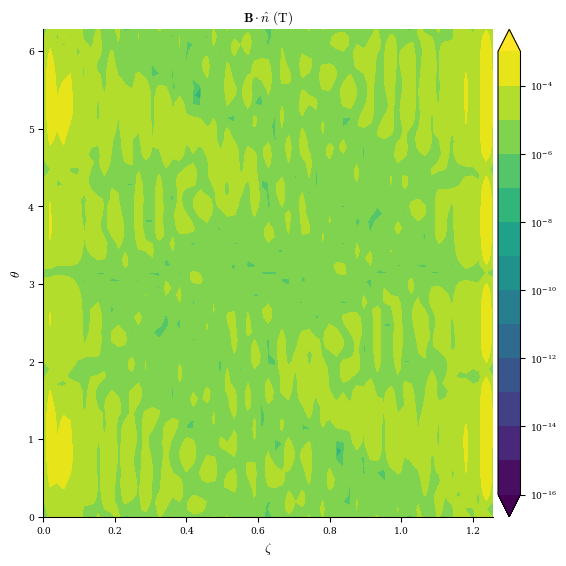

In [8]:
plot_2d(qfm_surf, "B*n", field=field, cmap="viridis", log=True);

We also see that the optimized surface is now a good approximation of a flux surface in this vacuum field

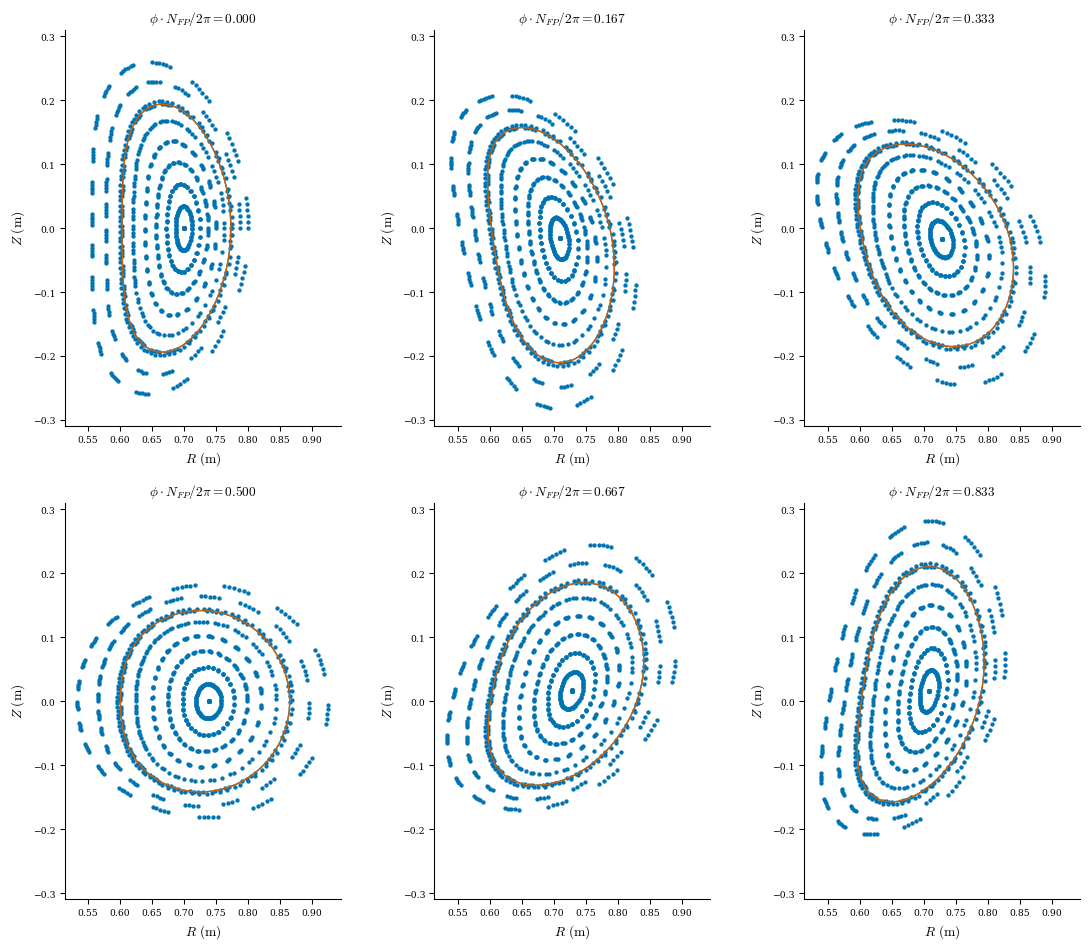

In [9]:
data = qfm_surf.compute(["R", "Z"], grid=LinearGrid(rho=1.0, theta=0, zeta=0))
fig, ax = plot_surfaces(qfm_surf, rho=1.0, theta=0)
poincare_plot(
    field, R0=np.append(data["R"], np.linspace(0.7, 0.8, 9)), Z0=np.zeros(10), ax=ax
);

We can use this QFM surface as the surface for a fixed-boundary DESC equilibrium solve, to find the equilibrium field which matches the vacuum field inside this surface. (Alternatively, one could also perform a free-boundary solve, though we know the surface should not change much from this QFM surface)

In [10]:
from desc.equilibrium import Equilibrium

eq = Equilibrium(surface=qfm_surf, Psi=-0.035, L=8, M=6, N=6)
eq.solve(verbose=3, ftol=1e-8);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 805 ms
Timer: Objective build = 1.14 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 613 ms
Timer: LinearConstraintProjection build = 5.00 sec
Number of parameters: 628
Number of objectives: 3250
Timer: Initializing the optimization = 6.86 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trus

Finally, we compare the solve equilibrium's flux surfaces with the vacuum field Poincare plot and confirm that indeed, the equilibrium matches the vacuum field as expected.

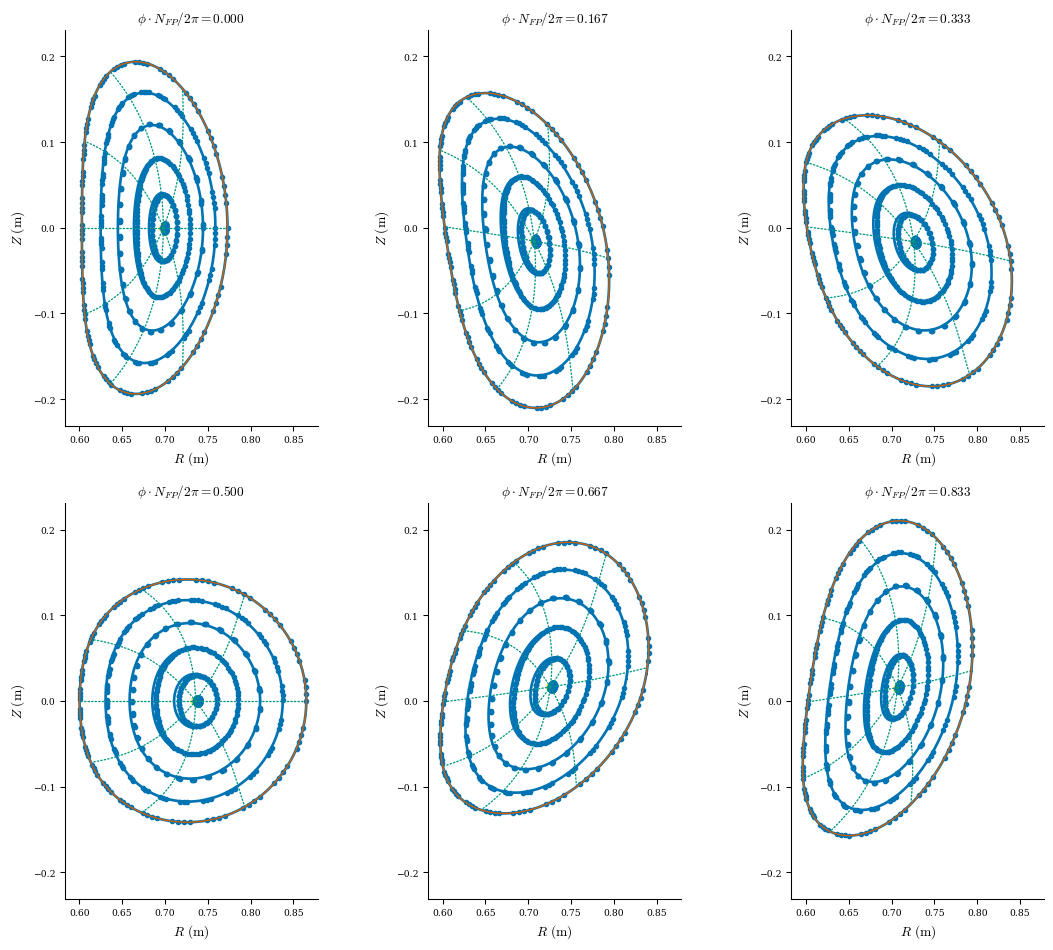

In [11]:
grid = LinearGrid(L=5)
data = eq.compute(["R", "Z"], grid=grid)
fig, ax = plot_surfaces(eq, rho=grid.nodes[:, 0], rho_lw=2)
poincare_plot(field, R0=data["R"], Z0=data["Z"], ax=ax, NFP=eq.NFP, size=10);